In [121]:
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

import theano.tensor as tt
import theano as th
import arviz as az

import altair as alt

# Generate data

We want to have a latent process that is evolving over time based on some data

In [300]:
%load_ext lab_black

<IPython.core.display.Javascript object>

In [427]:
size = 100
np.random.seed(15)

z0 = 0.5
ut = np.random.choice(np.arange(-2, 3), size=size)
zt = np.zeros(ut.shape[0])
yt = np.zeros(ut.shape[0])

A = np.full(size, 0.9)  # np.cos(np.linspace(0, 3*np.pi*2, size))
B = 2
C = 2
D = -2

Q = 2.9
R = 4
for i, u in enumerate(ut):
    if i == 0:
        zt[i] = z0
    else:
        zt[i] = A[i] * zt[i - 1] + B * ut[i] + np.random.normal(0, Q)
    yt[i] = C * zt[i] + D * (ut[i]) + np.random.normal(0, R)

<IPython.core.display.Javascript object>

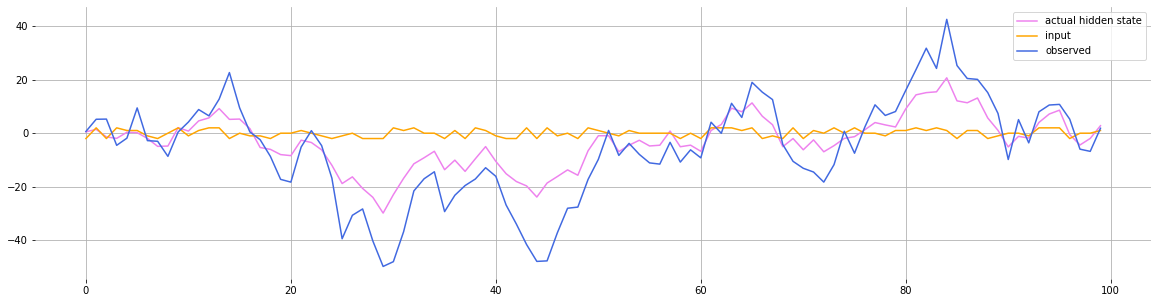

<IPython.core.display.Javascript object>

In [428]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(np.arange(ut.shape[0]), zt, color="violet", label="actual hidden state")
plt.plot(np.arange(ut.shape[0]), ut, color="orange", label="input")
plt.plot(np.arange(ut.shape[0]), yt, color="royalblue", label="observed")
plt.legend()
sns.despine(left=True, bottom=True)
plt.savefig("../../../../sidravi1.github.io/assets/20200620_simulated_data.png")

## Kalman Filter

![prediction](kalman_pred.png)

![prediction](kalman_measurement.png)

In [310]:
def prediction_step(mu_tm1, Sigma_tm1, A, B, Q, u):
    mu_t_tm1 = A * mu_tm1 + B * u
    Sigma_t_tm1 = A * Sigma_tm1 * A + Q

    return mu_t_tm1, Sigma_t_tm1


def measurement_step(mu_t_tm1, Sigma_t_tm1, y, u, C, D, R):
    S = C * Sigma_t_tm1 * C + R
    yt_hat = C * mu_t_tm1 + D * u

    rt = y - yt_hat
    K = Sigma_t_tm1 * C / S

    mu_t = mu_t_tm1 + K * rt
    Sigma_t = (1 - K * C) * Sigma_t_tm1

    return mu_t, Sigma_t

<IPython.core.display.Javascript object>

In [369]:
def kalman_filter(yt, ut, params):

    mu_t_tm1 = np.zeros_like(yt)
    Sigma_t_tm1 = np.ones_like(yt)

    mu_t = np.zeros_like(yt)
    Sigma_t = np.ones_like(yt)

    A_noised = params["A"]  # + np.random.normal(0, 1, size=size)
    B_noised = params["B"]  # + np.random.normal(0, 2)
    Q_noised = params["Q"]  # + np.random.normal(0, 1)
    C_noised = params["C"]  # + np.random.normal(0, 1)
    D_noised = params["D"]  # + np.random.normal(0, 1)
    R_noised = params["R"]  # + np.random.normal(0, 1)

    for t in range(1, yt.shape[0]):
        mu_t_tm1[t], Sigma_t_tm1[t] = prediction_step(
            mu_t[t - 1], Sigma_t[t - 1], A_noised[t], B_noised, Q_noised, ut[t]
        )
        mu_t[t], Sigma_t[t] = measurement_step(
            mu_t_tm1[t], Sigma_t_tm1[t], yt[t], ut[t], C_noised, D_noised, R_noised
        )

    return mu_t, Sigma_t

<IPython.core.display.Javascript object>

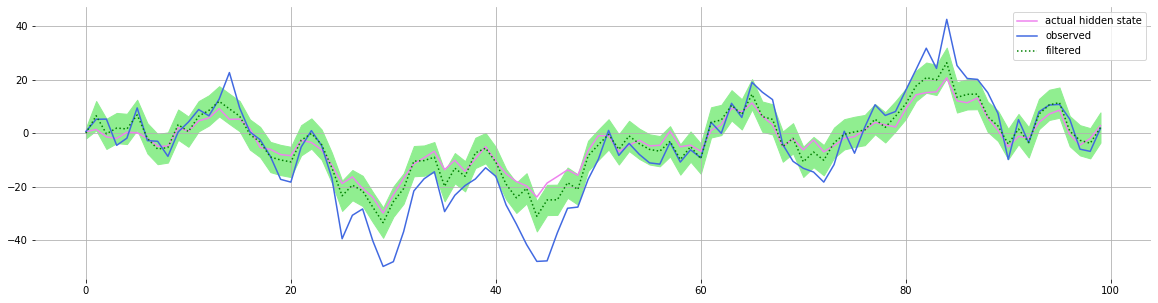

<IPython.core.display.Javascript object>

In [405]:
params = {}

params["A"] = A - 0.5
params["B"] = B + 1
params["Q"] = Q + 2
params["C"] = C - 1
params["D"] = D + 1
params["R"] = R + 2

mu_t, Sigma_t = kalman_filter(yt, ut, params)


plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(np.arange(ut.shape[0]), zt, color="violet", label="actual hidden state")
plt.plot(np.arange(ut.shape[0]), yt, color="royalblue", label="observed")
plt.plot(np.arange(ut.shape[0]), mu_t, ls=":", color="green", label="filtered")
plt.fill_between(
    np.arange(ut.shape[0]), mu_t + 2 * Sigma_t, mu_t - 2 * Sigma_t, color="lightgreen"
)
plt.legend()
sns.despine(left=True, bottom=True)
plt.savefig("../../../../sidravi1.github.io/assets/20200620_filtered_noised.png")

## Kalman Smoothing

In [406]:
def smoothing(A, mu_t, mu_tp1_T, mu_tp1_t, Sigma_t, Sigma_tp1_T, Sigma_tp1_t):
    J_t = Sigma_t * A / Sigma_tp1_t
    mu_t_T = mu_t + J_t * (mu_tp1_T - mu_tp1_t)
    Sigma_t_T = Sigma_t + J_t * (Sigma_tp1_T - Sigma_tp1_t) * J_t

    return mu_t_T, Sigma_t_T

<IPython.core.display.Javascript object>

In [407]:
T = yt.shape[0] - 1

mu_t_T = np.zeros_like(yt)
Sigma_t_T = np.zeros_like(yt)

mu_t_T[T] = mu_t[T]
Sigma_t_T[T] = Sigma_t[T]

for t in range(T - 1, -1, -1):
    mu_t_T[t], Sigma_t_T[t] = smoothing(
        params["A"][t],
        mu_t[t],
        mu_t_T[t + 1],
        mu_t_tm1[t + 1],
        Sigma_t[t],
        Sigma_t_T[t + 1],
        Sigma_t_tm1[t + 1],
    )

<IPython.core.display.Javascript object>

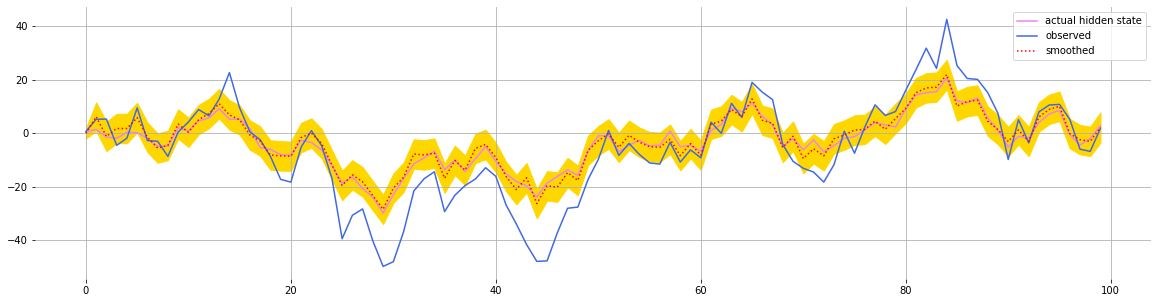

<IPython.core.display.Javascript object>

In [413]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(np.arange(ut.shape[0]), zt, color="violet", label="actual hidden state")
plt.plot(np.arange(ut.shape[0]), yt, color="royalblue", label="observed")
plt.plot(np.arange(ut.shape[0]), mu_t_T, ls=":", color="red", label="smoothed")
plt.fill_between(
    np.arange(ut.shape[0]),
    mu_t_T + 2 * Sigma_t_T,
    mu_t_T - 2 * Sigma_t_T,
    color="gold",
)
plt.legend()
sns.despine(left=True, bottom=True)
plt.savefig("../../../../sidravi1.github.io/assets/20200620_smoothed_noised.png")

In [402]:
np.corrcoef(zt, mu_t_T), np.corrcoef(zt, mu_t)

(array([[1.        , 0.98270757],
        [0.98270757, 1.        ]]), array([[1.        , 0.98340662],
        [0.98340662, 1.        ]]))

<IPython.core.display.Javascript object>

# Fitting using pymc3

In [439]:
class LinearGaussianSSM(pm.distributions.distribution.Continuous):
    """
    Linear Gaussian SSM with 1 lag.
    Parameters
    ----------
    k: tensor
       effect of lagged value on current value
    tau_e: tensor
       precision for innovations
    mu: tensor
       the mean shift for the process
    """

    def __init__(self, k, tau_e, mu, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k = tt.as_tensor_variable(k)
        self.tau_e = tau_e = tt.as_tensor_variable(tau_e)
        self.tau = tau_e * (1 - k ** 2)
        self.mode = tt.as_tensor_variable(0.0)
        self.mu = tt.as_tensor_variable(mu)

    def logp(self, x):
        """
        Calculate log-probability of LG-SSM distribution at specified value.
        Parameters
        ----------
        x: numeric
            Value for which log-probability is calculated.
        Returns
        -------
        TensorVariable
        """
        k = self.k
        tau_e = self.tau_e  # innovation precision
        tau = tau_e * (1 - k[0] ** 2)  # ar1 precision
        mu = self.mu

        x_im1 = x[:-1]
        x_i = x[1:]
        boundary = pm.Normal.dist(0, tau=tau).logp

        innov_like = pm.Normal.dist(k * x_im1 + mu, tau=tau_e).logp(x_i)
        return boundary(x[0]) + tt.sum(innov_like)

    def _repr_latex_(self, name=None, dist=None):
        if dist is None:
            dist = self
        k = dist.k
        tau_e = dist.tau_e
        name = r"\text{%s}" % name
        return r"${} \sim \text{{LGSSM1}}(\mathit{{k}}={},~\mathit{{tau_e}}={},~\mathit{{mu}}={})$".format(
            name, get_variable_name(k), get_variable_name(tau_e), get_variable_name(mu)
        )

<IPython.core.display.Javascript object>

In [414]:
n_samples = 500
with pm.Model() as model:

    sig = pm.HalfNormal("σ", 4)

    alpha = pm.Beta("alpha", alpha=1, beta=3)
    sig1 = pm.Deterministic(
        "σ1", alpha * sig
    )  # pm.HalfNormal('σ1', 2) #pm.Deterministic('σ1', alpha * 4)
    sig2 = pm.Deterministic(
        "σ2", (1 - alpha) * sig
    )  # pm.HalfNormal('σ2', 2) #pm.Deterministic('σ2', (1 - alpha) * 4)

    A_ = pm.Uniform("A_", -1, 1)
    B_ = pm.HalfNormal("B_", 2)
    mu = B_ * ut[1:]

    f = LinearGaussianSSM("z", k=A_, tau_e=1 / (sig1 ** 2), mu=mu, shape=yt.shape)

    C_ = pm.HalfNormal("C_", 2)
    D_ = pm.Normal("D_", 0, 2)
    y_mu = pm.Deterministic("y_mu", C_ * f + D_ * ut)

    likelihood = pm.Normal("y", mu=y_mu, sd=sig2, observed=yt)

    trace = pm.sample(1000, target_accept=0.99, tune=3000)

INFO (theano.gof.compilelock): Refreshing lock /Users/sidravi/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.7-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/sidravi/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.7-64/lock_dir/lock
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_, C_, z, B_, A_, alpha, \sigma]
INFO:pymc3:NUTS: [D_, C_, z, B_, A_, alpha, \sigma]
Sampling 4 chains, 4 divergences: 100%|██████████| 16000/16000 [02:02<00:00, 130.64draws/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/sidravi/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.7-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/sidravi/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.7-64/

<IPython.core.display.Javascript object>

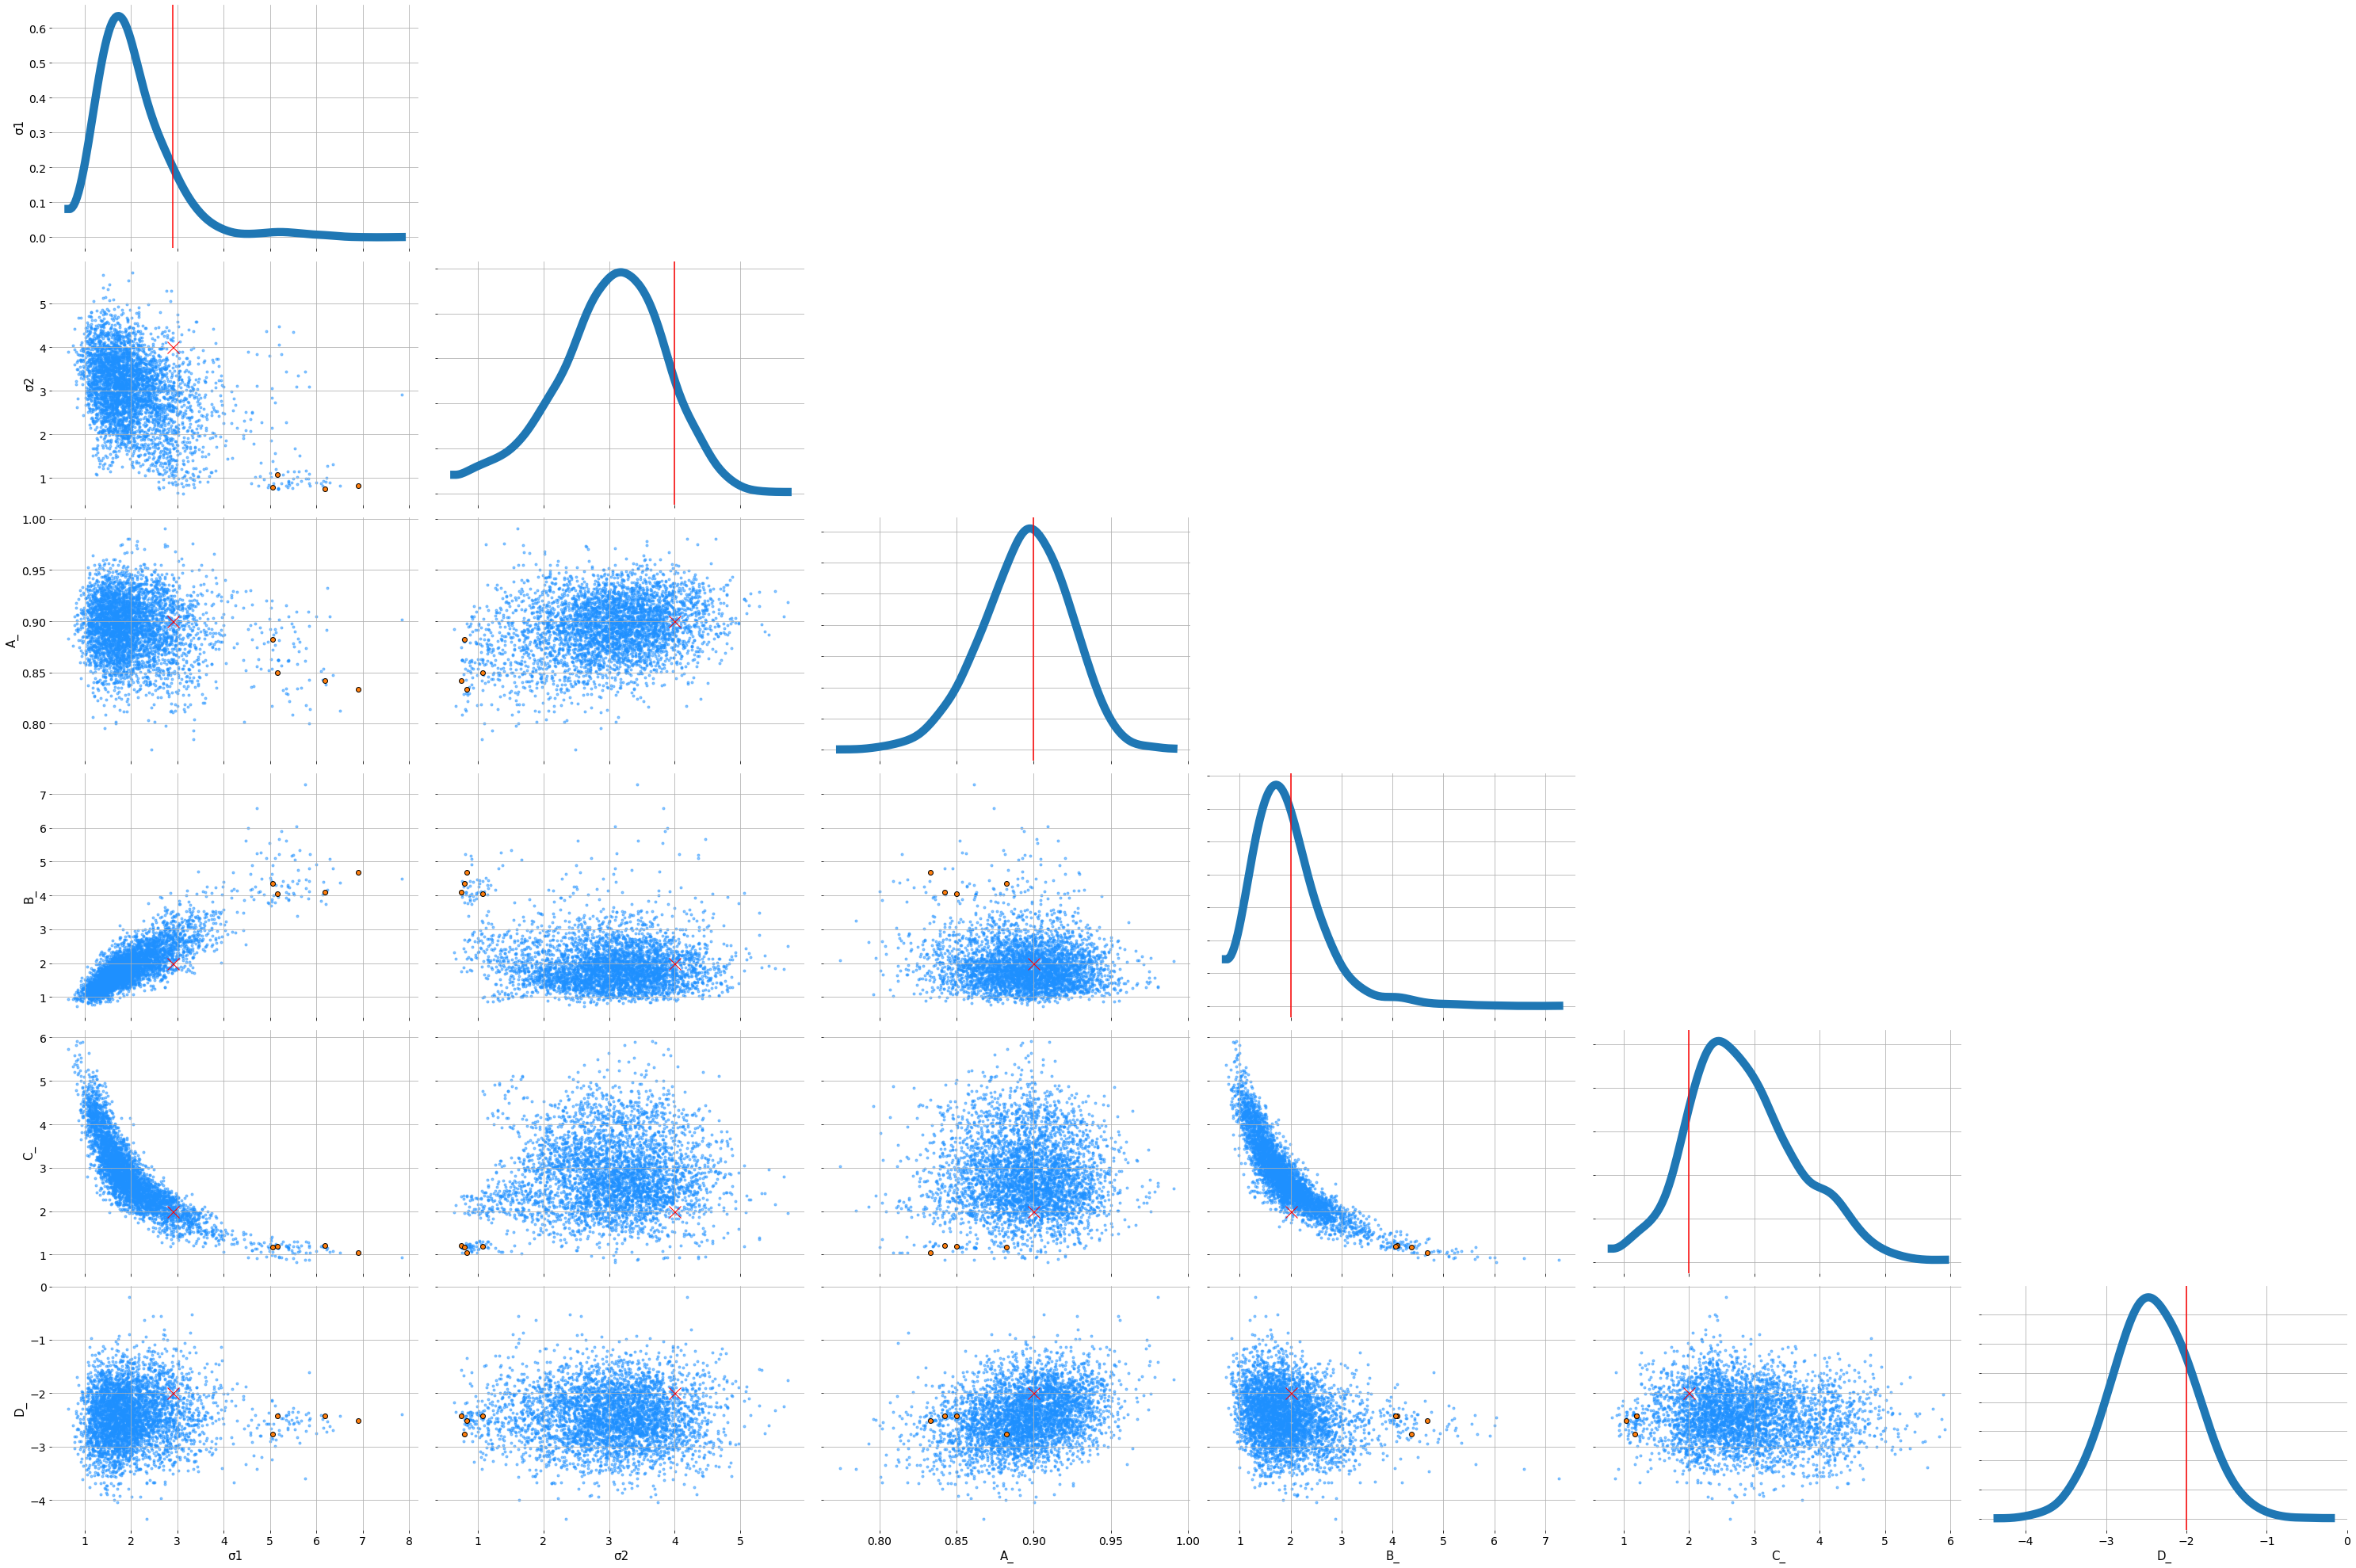

<IPython.core.display.Javascript object>

In [429]:
axes = az.plots.pairplot.plot_pair(
    trace,
    var_names=["σ1", "σ2", "A_", "B_", "C_", "D_"],
    scatter_kwargs={"alpha": 0.5, "color": "dodgerblue"},
    reference_values=dict(
        zip(["σ1", "σ2", "A_", "B_", "C_", "D_"], [Q, R, A[0], B, C, D])
    ),
    marginals=True,
    reference_values_kwargs={"color": "red", "ms": 15, "marker": "x"},
    divergences=True,
)

i_next = 0
i_increment = 2
for i, (ax_row, val) in enumerate(zip(axes, [Q, R, A[0], B, C, D])):
    for ax in ax_row:
        ax.grid()
        sns.despine(left=True, bottom=True, ax=ax)
    ax_row[i].axvline(x=val, color="r")
plt.tight_layout()
plt.savefig("../../../../sidravi1.github.io/assets/20200620_pair_plot.png")

In [416]:
ppc = pm.sample_posterior_predictive(trace, model=model)

100%|██████████| 4000/4000 [00:04<00:00, 945.91it/s]


<IPython.core.display.Javascript object>

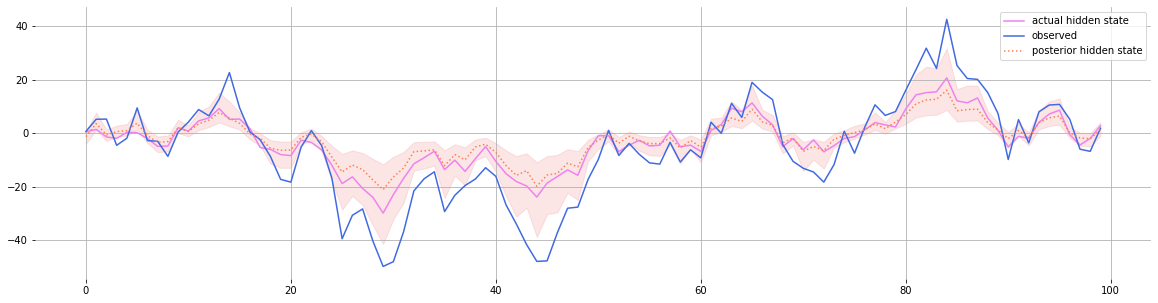

<IPython.core.display.Javascript object>

In [434]:
t = np.arange(ut.shape[0])

plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(np.arange(ut.shape[0]), zt, color="violet", label="actual hidden state")
plt.plot(np.arange(ut.shape[0]), yt, color="royalblue", label="observed")
plt.legend()
plt.plot(
    t, np.mean(trace["z"], axis=0), ":", color="coral", label="posterior hidden state"
)
plt.fill_between(
    t, *np.percentile(trace["z"], q=[2.5, 97.5], axis=0), color="lightcoral", alpha=0.2
)
plt.legend()
sns.despine(left=True, bottom=True)
plt.savefig("../../../../sidravi1.github.io/assets/20200620_posterior_zt.png")
# plt.plot(t, ppc['y'].mean(axis=0))

## With changing A

In [440]:
size = 100
np.random.seed(15)

z0 = 0.5
ut = np.random.choice(np.arange(-2, 3), size=size)
zt = np.zeros(ut.shape[0])
yt = np.zeros(ut.shape[0])

A = 0.9 * np.cos(np.linspace(0, 2 * np.pi * 2, size))
B = 2
C = 2
D = 0

Q = 2.9
R = 4
for i, u in enumerate(ut):
    if i == 0:
        zt[i] = z0
    else:
        zt[i] = A[i] * zt[i - 1] + B * ut[i] + np.random.normal(0, Q)
    yt[i] = C * zt[i] + D * (ut[i]) + np.random.normal(0, R)

<IPython.core.display.Javascript object>

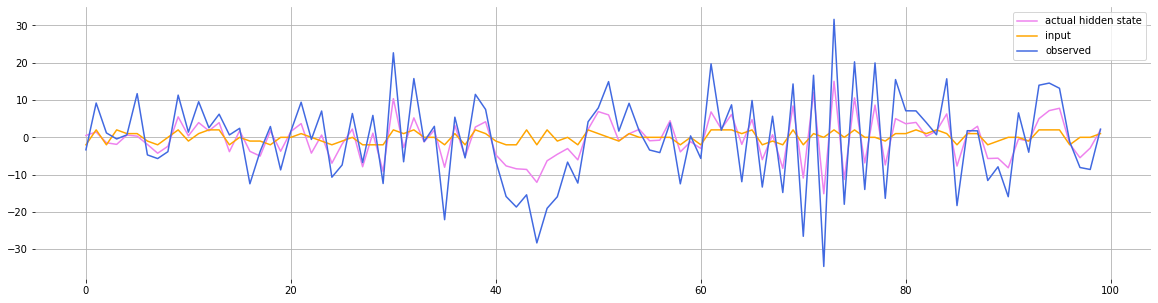

<IPython.core.display.Javascript object>

In [449]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(np.arange(ut.shape[0]), zt, color="violet", label="actual hidden state")
plt.plot(np.arange(ut.shape[0]), ut, color="orange", label="input")
plt.plot(np.arange(ut.shape[0]), yt, color="royalblue", label="observed")
plt.legend()
sns.despine(left=True, bottom=True)
plt.savefig("../../../../sidravi1.github.io/assets/20200620_simulated_data_cos.png")

In [442]:
from theano.ifelse import ifelse

<IPython.core.display.Javascript object>

In [447]:
n_samples = 500
with pm.Model() as model2:

    sig = pm.HalfNormal("σ", 4)

    alpha = pm.Beta("alpha", alpha=1, beta=3)
    sig1 = pm.Deterministic(
        "σ1", alpha * sig
    )  # pm.HalfNormal('σ1', 2) #pm.Deterministic('σ1', alpha * 4)
    sig2 = pm.Deterministic(
        "σ2", (1 - alpha) * sig
    )  # pm.HalfNormal('σ2', 2) #pm.Deterministic('σ2', (1 - alpha) * 4)

    # A_base = np.linspace(0, 1 , size-1)
    # phase= pm.Uniform('phase', -np.pi+0.1, np.pi)

    # A_ = pm.math.sin(A_base* 4*np.pi + phase)
    # A_ = pm.Uniform('A_', -1, 1)
    # BoundedGRW = pm.Bound(pm.GaussianRandomWalk, lower=-1.0, upper=1.0)
    A_sigma = pm.HalfNormal("A_sigma", 0.2)
    A_ = pm.GaussianRandomWalk(
        "A_", mu=0, sigma=A_sigma, shape=(size), testval=tt.zeros(size)
    )

    B_ = pm.HalfNormal("B_", 2)
    mu = B_ * ut[1:]

    f = LinearGaussianSSM("z", k=A_[1:], tau_e=1 / (sig1 ** 2), mu=mu, shape=yt.shape)

    C_ = pm.HalfNormal("C_", 2)
    D_ = pm.Normal("D_", 0, 2)
    y_mu = pm.Deterministic("y_mu", C_ * f + D_ * ut)

    likelihood = pm.Normal("y", mu=y_mu, sd=sig2, observed=yt)

    trace2 = pm.sample(1000, target_accept=0.99, tune=3000)

<IPython.core.display.Javascript object>

In [ ]:
ppc2 = pm.sample_posterior_predictive(trace2, model = model2)

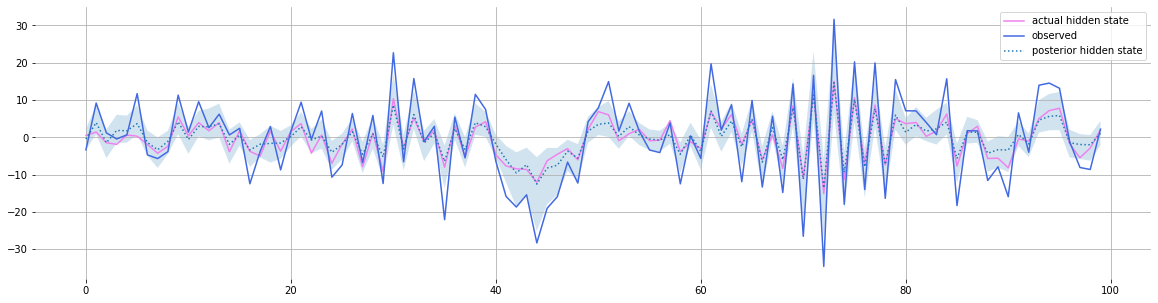

<IPython.core.display.Javascript object>

In [444]:
t = np.arange(ut.shape[0])

plt.figure(figsize=(20, 5))
plt.plot(np.arange(ut.shape[0]), zt, color="violet", label="actual hidden state")
plt.plot(np.arange(ut.shape[0]), yt, color="royalblue", label="observed")
plt.grid()
plt.plot(t, np.mean(trace2["z"], axis=0), ":", label="posterior hidden state")
plt.fill_between(t, *np.percentile(trace2["z"], q=[2.5, 97.5], axis=0), alpha=0.2)
plt.legend()

sns.despine(left=True, bottom=True)
plt.savefig("../../../../sidravi1.github.io/assets/20200620_posterior_cos.png")

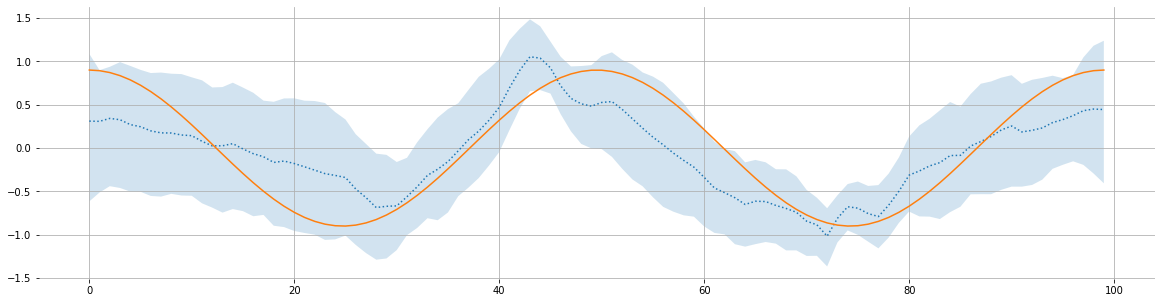

<IPython.core.display.Javascript object>

In [448]:
plt.figure(figsize=(20, 5))

plt.plot(t, np.mean(trace2["A_"], axis=0), ":", label="A: Posterior")
plt.fill_between(t, *np.percentile(trace2["A_"], q=[2.5, 97.5], axis=0), alpha=0.2)
plt.grid()
sns.despine(left=True, bottom=True)
plt.plot(t, A, "-", label="A: Actual")
plt.savefig("../../../../sidravi1.github.io/assets/20200620_A_posterior.png")

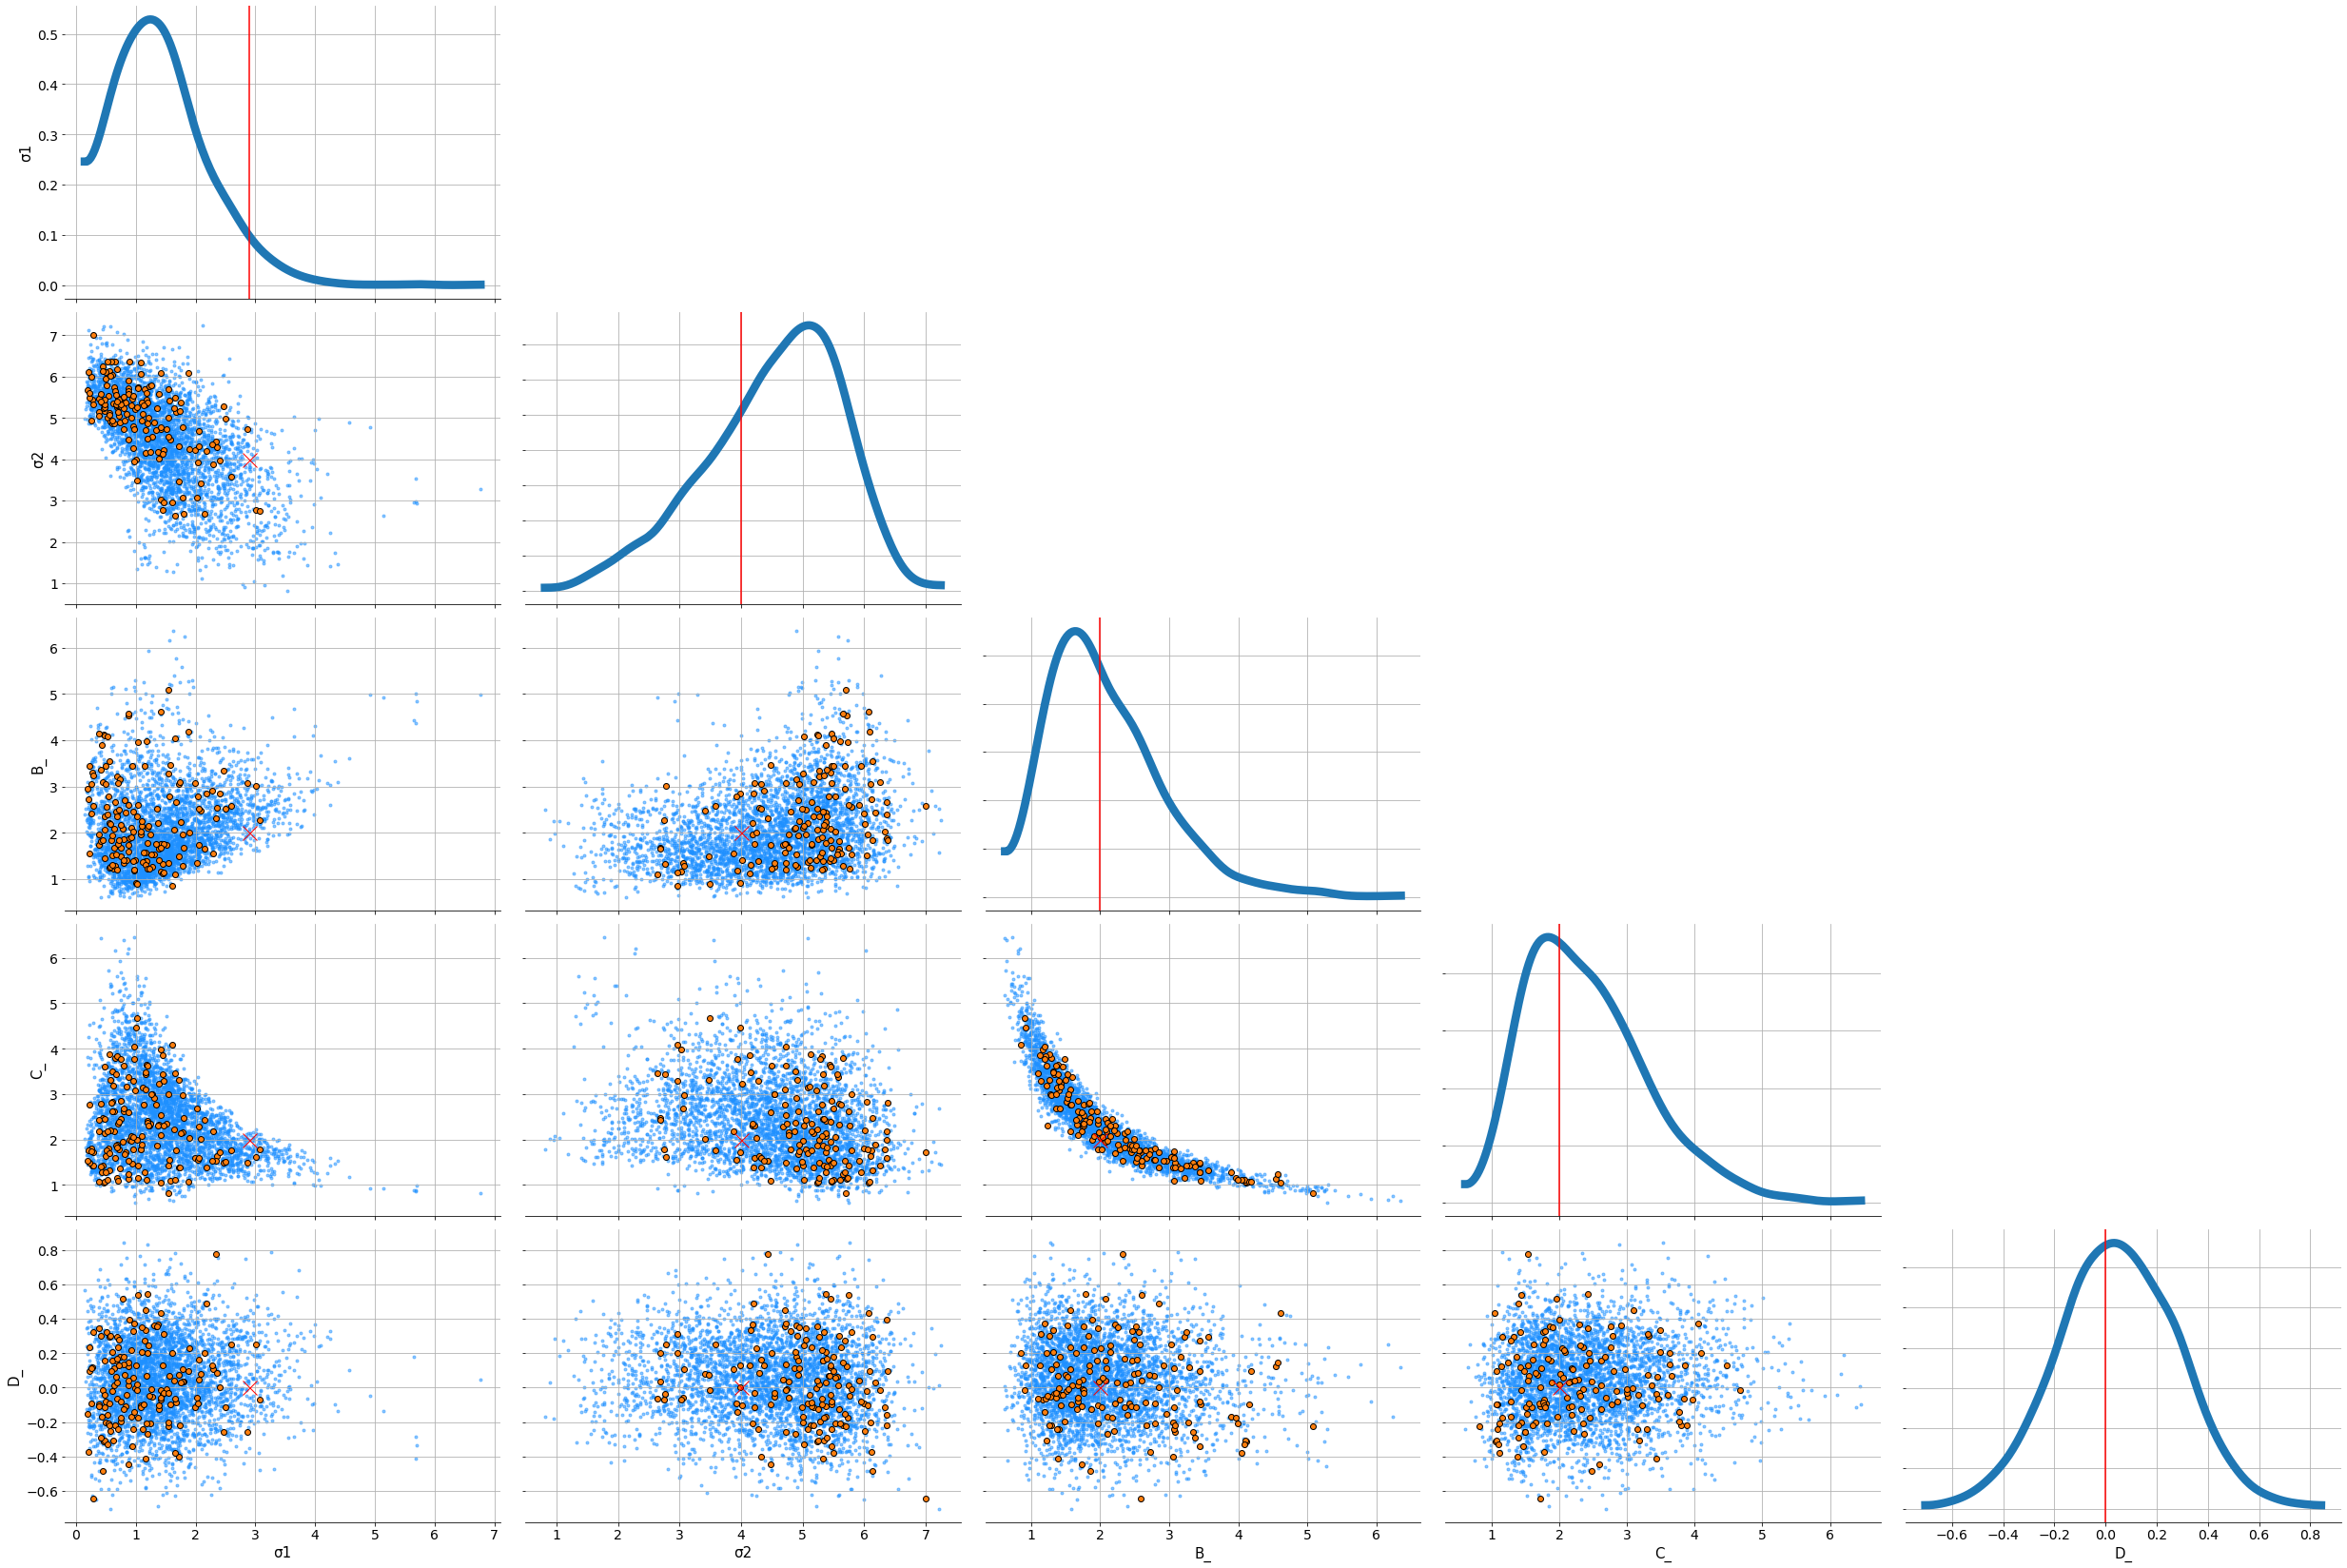

In [170]:
axes = az.plots.pairplot.plot_pair(trace2, var_names=['σ1', 'σ2', 'B_', 'C_', "D_"], 
                            scatter_kwargs={'alpha':0.5, 'color':'dodgerblue'},
                            reference_values = dict(zip(['σ1', 'σ2', 'B_', 'C_', "D_"], [Q, R, B, C, D])), 
                            marginals=True, 
                            reference_values_kwargs={'color':'red', 'ms':15, 'marker': 'x'},
                            divergences=True);

i_next = 0
i_increment = 2
for i, (ax_row, val) in enumerate(zip(axes, [Q, R, B, C, D])):
    for ax in ax_row:
        ax.grid()
        sns.despine(left=True, right=True, ax=ax)
    ax_row[i].axvline(x = val, color='r')
plt.tight_layout()